In [46]:
from importlib import reload
import backtest
import order_book
import signal_1
import scipy.odr as odr

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI

In [35]:
# Loading "pairs trade" buckets
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'
with open(os.path.join(COR_DIR, "correlation_buckets_no_shorts.pkl"), "rb") as file:
    BUCKETS = pickle.load(file)

In [36]:
# Concatenating dictionary value lists
UNIVERSE=[]
for i in list(BUCKETS.values()):
    UNIVERSE.extend(i)

In [37]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
### loading in low frequency data
if len(mid_df) == 0:
    mid_df = DataLoader.getPrices(UNIVERSE, "day", logDir=os.path.join(DIR,"Beta_Callibration"), _parallel=True)
    MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE, "minute", logDir=DIR, _parallel=True)
    HIGH_LOADED = True


## Analysis of first correlation bucket

In [38]:
BUCKETS

{'AOA': ['AOA', 'SPXS', 'SPXU', 'SH', 'SDS'],
 'AIQ': ['AIQ', 'SQQQ', 'QID', 'PSQ'],
 'AGQ': ['AGQ', 'ZSL'],
 'AGG': ['AGG', 'TTT', 'TYO', 'TMV', 'TBT', 'TBX', 'PST'],
 'ACWX': ['ACWX', 'EPV', 'EFZ', 'EFU'],
 'ACWI': ['ACWI', 'SPXU', 'SPXS', 'SH', 'SDS'],
 'AAXJ': ['AAXJ', 'EUM', 'EEV'],
 'ZSL': ['ZSL', 'SLV', 'SIVR', 'GLTR'],
 'ZROZ': ['ZROZ', 'TMV', 'TTT', 'TBT'],
 'XBI': ['XBI', 'LABD'],
 'YCL': ['YCL', 'YCS'],
 'YINN': ['YINN', 'YANG', 'YXI', 'FXP'],
 'YCS': ['YCS', 'FXY'],
 'YXI': ['YXI', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'YANG': ['YANG', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'XT': ['XT', 'HIBS'],
 'XTR': ['XTR', 'SQQQ', 'SPXS', 'SPXU', 'SH', 'SDS', 'QID', 'PSQ'],
 'XSOE': ['XSOE', 'EUM', 'EEV'],
 'XSVM': ['XSVM', 'TWM', 'TZA', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XSMO': ['XSMO', 'TZA', 'TWM', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XPP': ['XPP', 'FXP'],
 'XNTK': ['XNTK', 'SQQQ', 'SOXS', 'QID', 'PSQ'],
 'XMLV': ['XMLV', 'SMDD'],
 'XMMO': ['XMMO', 'SMDD'],
 'XLG': ['XLG', 

In [180]:
bucket_mask = lambda price_data: price_data[0] in BUCKETS[list(BUCKETS.keys())[1]]
hf_bucket = dict(filter(bucket_mask, high_df.items()))
mf_bucket = dict(filter(bucket_mask, mid_df.items()))

### Need to find weighting for positions in portfolio

In [181]:
beta = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\^FTW5000_beta.csv')
beta = beta.loc[:, ~beta.columns.str.contains('^Unnamed')]
beta['Beta'] = [float(x.split(",")[0][1:]) for x in beta['Beta']]
beta = beta[beta.apply(bucket_mask, axis=1)]
beta = beta.set_index("Ticker")
beta = beta.to_dict()['Beta']

C:\Users\raymo\AppData\Local\Temp\ipykernel_51272\3744329683.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_mask = lambda price_data: price_data[0] in BUCKETS[list(BUCKETS.keys())[1]]


In [182]:
corr = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\pairwise_corr.csv')
corr = corr.loc[:, ~corr.columns.str.contains('^Unnamed')]
bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2
corr = corr[corr.apply(bucket_corr_mask, axis=1)]
corr = corr.sort_values(by="Cross Correlation")
corr

C:\Users\raymo\AppData\Local\Temp\ipykernel_51272\4063414317.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2


,Ticker Pair,Cross Correlation
7085,"AOA,SPXS",-0.929647
7087,"AOA,SPXU",-0.928230
7130,"AOA,SDS",-0.927236
7126,"AOA,SH",-0.913910
129151,"SPXS,SH",0.978531
128576,"SPXU,SH",0.990202
129164,"SPXS,SDS",0.992771
152082,"SH,SDS",0.993211
128529,"SPXU,SPXS",0.994507
128584,"SPXU,SDS",0.998731


In [184]:
hf_df = pd.DataFrame()
for ticker in hf_bucket:
    if len(hf_df) == 0:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = temp.set_index('timestamp')
    else:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = hf_df.join(temp.set_index('timestamp'),
                       how = 'left')
hf_df = hf_df.fillna(method='ffill')

C:\Users\raymo\AppData\Local\Temp\ipykernel_51272\3852191956.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hf_df = hf_df.fillna(method='ffill')


In [185]:
from importlib import reload
import OptimizationEngine.mipEngine
reload(OptimizationEngine.mipEngine)
logReturnTransform = lambda df : np.log(df) - np.log(df.shift(1))

mf_summary = {}
for data in mf_bucket:
    mu = mf_bucket[data][data].mean()
    std = mf_bucket[data][data].std()
    mu_hf = logReturnTransform(hf_bucket[data]['close']).mean()
    std_hf = logReturnTransform(hf_bucket[data]['close']).std()
    mf_summary[data] = {"Mu": mu, "Sigma":std, "Beta":beta[data],
                        "Mu_Min": mu_hf, "Sigma_Min": std_hf}
mf_summary = pd.DataFrame(mf_summary)
mf_summary

,AIQ,SQQQ,PSQ,QID
Mu,0.001250,-0.003814,-0.001162,-0.002418
Sigma,0.012776,0.034820,0.011696,0.023318
Beta,-0.006812,0.002798,0.007558,0.003955
Mu_Min,0.000029,-0.000009,-0.000005,-0.000010
Sigma_Min,0.003165,0.001348,0.000909,0.001202


## Running Ordinary Linear Regression for Weighting

In [186]:
hf_df.to_csv(r'C:\Users\raymo\OneDrive\Desktop\test.csv')

In [176]:
import pandas as pd
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold#define cross-validation method to evaluate model

def RidgeRegression(X,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = RidgeCV(alphas=arange(0, 1, 0.01), 
                    cv=cv, 
                    scoring='neg_mean_absolute_error',
                    fit_intercept=False)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model


def ElasticNet(X,y, l1=0.5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    #define model
    model = ElasticNetCV(alphas=arange(0, 1, 0.01), 
                    cv=cv,
                    fit_intercept=False,
                    positive=True,
                    l1_ratio=l1)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model

In [187]:
def tls(X, y):
    """
    Performs Total Least Squares regression.

    Args:
        X (numpy.ndarray): Design matrix (n_samples, n_features)
        y (numpy.ndarray): Target vector (n_samples,)

    Returns:
        numpy.ndarray: Estimated coefficients (n_features,)
    """

    # Construct augmented matrix
    A = np.hstack((X, y.reshape(-1, 1)))

    # Perform SVD
    U, S, V = np.linalg.svd(A)

    # Extract coefficients
    Vxy = V[-1, :-1]
    Vyy = V[-1, -1]

    return -Vxy / Vyy

In [188]:
# Define a function (quadratic in our case)
# to fit the data with.
# odr initially assumes a linear function
def f(B, x):
    return B[0] + np.dot(B[1:], x)  # B[0] is the intercept, B[1:] are the slopes

reference_ticker = 'AIQ'
x_temp = hf_df.loc[:, ~hf_df.columns.str.contains(reference_ticker)]
x_temp = -1*logReturnTransform(x_temp).iloc[1:]
# x1=  np.array(x_temp['SPXS'])
# x2= np.array(x_temp['SPXU'])
# x3 = np.array(x_temp['SH'])
# x4=np.array(x_temp['SDS'])
# x = np.column_stack((x1,x2,x3,x4))
x = np.array(x_temp)
y = np.array(logReturnTransform(hf_df[reference_ticker]).iloc[1:])

#  model fitting.
odr_model = odr.Model(f)
 
# Create a Data object using sample data created.
data = odr.Data(x, y)
 
# # Set ODR with the model and data.
# ordinal_distance_reg = odr.ODR(data, odr_model,
#                                beta0=[0] + [1]*x.shape[1])
 
# # Run the regression.
# out = ordinal_distance_reg.run()
 
# # print the results
# out.pprint()

# ElasticNet(x,y, 0)
RidgeRegression(x,y)

# # Plot the data and the fit
# plt.scatter(x, y)
# plt.plot(x, out.beta[0] * x + out.beta[1], color='red')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Orthogonal Linear Regression')
# plt.show()

[0.11236854 0.07498376 0.03479219]


RidgeCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
        fit_intercept=False, scoring='neg_mean_absolute_error')

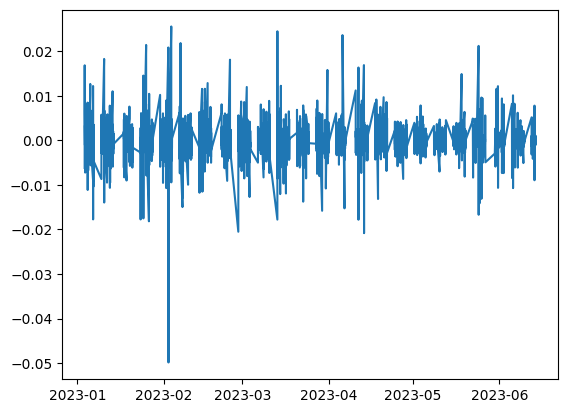

In [190]:
# coeffs = [0.07848097, 0.07975367, 0.02341106, 0.05056444]
coeffs = [0.11236854, 0.07498376, 0.03479219]
positive_legs = hf_df.loc[:, ~hf_df.columns.str.contains(reference_ticker)]
signal = positive_legs.apply(lambda dr:np.dot(np.array(dr), coeffs), axis = 1) + hf_df[reference_ticker]
signal
plt.plot(signal.pct_change())

In [132]:
y[-1]

65.79

In [ ]:
bounds = {'Mu':0, 'Sigma':0, 'Beta':0, 'Mu_Min':0, 'Sigma_Min':0}
MIP = OptimizationEngine.mipEngine.mipEngine()
# MIP._addVariables(mf_summary.columns, var_bounds=(None,None), var_type="INTEGER")
MIP._addConstraints(mf_summary, bounds, var_bounds=(1,None))
MIP._optimize()
#pd.DataFrame(mf_summary)

## Portfolio Optimization

## Grid Search for Strongest Mean Reversion Strategy

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
## analysis between adr spread and volume pct
df = combined[:-30]

df.fillna(method='ffill', inplace=True)
df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_Volume'] +df['TSM_Volume'])
mean = df['ADR_Vol_Pct'].mean()
std = df['ADR_Vol_Pct'].std()
df['ADR_Vol_Pct'] = (df['ADR_Vol_Pct'] - mean)/std
df['ADR_Spread'] = df['TSM_Close'] - df['TSMC34_SA_Close']
mean = df['ADR_Spread'].mean()
std = df['ADR_Spread'].std()
df['ADR_Spread'] = (df['ADR_Spread'] - mean)/std
coint_test_result = coint_johansen(df[['ADR_Vol_Pct','ADR_Spread']], det_order=0, k_ar_diff=1)
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt
for i, (stock1, stock2) in enumerate([('ADR_Vol_Pct', 'ADR_Spread')]):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

In [ ]:
import statsmodels.api as sm
# adding the constant term
x = df[['ADR_Spread']].shift(1)[1:]#.tolist()
y = df['ADR_Spread'][1:].tolist()
#x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()
 
# printing the summary table
print(result.summary())

In [ ]:
result.coef()

In [ ]:

df['ADR_Vol_MA20'] = df['ADR_Vol_Pct'].rolling(20).mean()
df['ADR_1sd_MA20'] = df['ADR_Vol_Pct'].rolling(20).std()
df['primitive_signal'] = df.apply(lambda dr: 1 if dr.ADR_Vol_Pct < dr.ADR_Vol_MA20 - dr.ADR_1sd_MA20 else 0, axis=1).rolling(5).mean()
## add persistence to signal - to optimize
df['Signal'] = [1 if x > 0 else 0 for x in df['primitive_signal']]
df['BuySell'] = df['Signal'] - df['Signal'].shift(1)
df["index"] = pd.to_datetime(df["index"])
df

In [ ]:
BBO = order_book.Book()
for row in df.itertuples():
    if (row.BuySell == 1):
        print('bought spread at ', row.index)
        BBO.addOrder(row.index, "TSM", row.TSM_Close, -100)
        BBO.addOrder(row.index, "TSMC34_SA", row.TSMC34_SA_Close, 150)
    elif (row.BuySell == -1):
        print('sold spread at ', row.index)
        BBO.addOrder(row.index, "TSM", row.TSM_Close, 100)
        BBO.addOrder(row.index, "TSMC34_SA", row.TSMC34_SA_Close, -150)
#BBO.addOrder(df_res.iloc[100]["Date"], "TSM", 300.0, 10)
#BBO.addOrder(df_res.iloc[120]["Date"], "TSM", 250.0, 25)
#BBO.addOrder(df_res.iloc[200]["Date"], "TSM", 350.0, -30)
#BBO.getTickerBook(["TSLA"]).tail(1)#.loc['Quantity']
#BBO.get_history()

#BBO.addOrder(df_res.iloc[50]["Date"], "TSMC34.SA", 300.0, 10)
#BBO.addOrder(df_res.iloc[150]["Date"], "TSMC34.SA", 250.0, -25)

In [ ]:
BBO.getHistoryDf().Date

In [ ]:
df = df.rename(columns={"index":"Date"})
df1 = df[['Date', 'TSMC34_SA_Close']]
df2 = df[['Date', 'TSM_Close']]
df1['Ticker'] = 'TSMC34_SA'
df2['Ticker'] = 'TSM'

df_res = pd.concat([df1.rename(columns={'TSMC34_SA_Close':'Price'}),df2.rename(columns={'TSM_Close':'Price'})])
print(df_res)
#df1.drop('index', inplace=True)
#df_res.rename(columns={'Datetime':'Date'}, inplace=True)
df_res# = df1[['Date', 'Ticker']]
BBO.backfillPnL(df_res)

In [71]:
hist = BBO.getHistoryDf()

In [ ]:
BBO.getTickerBook(['TSM'])

In [ ]:
plt.plot(hist[['PnL']])
plt.show()

In [ ]:
print(hist)

In [ ]:
BBO.get_books()

In [ ]:
hist